In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#reading the cash_request file
#cash_request = pd.read_csv("/content/extract - cash request - data analyst.csv")
cash_request = pd.read_parquet("cleaned_requests.parquet", engine="pyarrow")
#fees = pd.read_csv("/content/extract - fees - data analyst - .csv")
fees = pd.read_parquet("cleaned_fees.parquet", engine="pyarrow")
cash_request.info()
fees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   id                          23970 non-null  int64              
 1   amount                      23970 non-null  float64            
 2   status                      23970 non-null  object             
 3   created_at                  23970 non-null  datetime64[ns, UTC]
 4   updated_at                  23970 non-null  datetime64[ns, UTC]
 5   user_id                     21867 non-null  Int64              
 6   moderated_at                15912 non-null  datetime64[ns, UTC]
 7   deleted_account_id          2104 non-null   Int64              
 8   reimbursement_date          3050 non-null   datetime64[ns, UTC]
 9   cash_request_received_date  16289 non-null  datetime64[ns, UTC]
 10  money_back_date             12040 non-null  datetime64[ns,

In [77]:
#merging both datasets 
merged_df = pd.merge(left = cash_request, right= fees, left_on= "id", right_on="cash_request_id", how = "left")
#merged_df.sort_values(by="id_x")
#merged_df.info()
#check duplicates
#duplicates = merged_df[merged_df.duplicated(subset=["id_x"], keep=False)]
#duplicates.head()
#duplicated ids for cash requests due to different incidents per cash request


In [78]:
#merged_df.to_csv("merged_data_ironhack_payment")
#renaming columns
#merged_df = merged_df.rename(columns={"amount" : "amount_CR", "status_x" : "status_CR", "status_y" : "status_fees", "total_amount" : "amount_fees", "created_at_x" : "created_at_CR", "id_x" : "id_CR"})
#print(merged_df.shape)
#merged_df.head()
#merged_df.info()

In [79]:
#CR status money sent
cash_request["status"].value_counts()
money_back = cash_request[cash_request["reimbursement_date"].notna()]
#money_back

In [80]:
#fill empty IDs with IDs from deleted accounts
cash_request["user_id"] = cash_request["user_id"].fillna(cash_request["deleted_account_id"]) #empty user ids for accounts that have been deleted or for requests that have been rejected

In [81]:
#convert creat_at column to datetime
#cash_request["created_at"] = pd.to_datetime(cash_request["created_at"])

# group by user and take the first created date as cohort month
cash_request["cohort_month"] = cash_request.groupby("user_id")["created_at"].transform("min")
cash_request["cohort_month"] = cash_request["cohort_month"].dt.to_period("M") #transforming to period
cash_request["cohort_month"] = cash_request["cohort_month"].fillna("deleted or rejected")

# take created_date as usage_date
cash_request["usage_month"] = cash_request["created_at"].dt.to_period("M")

C:\Users\Anast\AppData\Local\Temp\ipykernel_9552\2383033609.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request["cohort_month"] = cash_request["cohort_month"].dt.to_period("M") #transforming to period
C:\Users\Anast\AppData\Local\Temp\ipykernel_9552\2383033609.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request["usage_month"] = cash_request["created_at"].dt.to_period("M")


In [82]:
#time to reimburse
cash_request["reimbursement_date"] = pd.to_datetime(cash_request["reimbursement_date"])
cash_request["time_to_reimburse"] = cash_request["reimbursement_date"] - cash_request["created_at"]
cash_request["time_to_reimburse"] = cash_request["time_to_reimburse"].dt.days
cash_request_reimbursement = cash_request[cash_request["time_to_reimburse"].notna()]
cash_request_reimbursement.describe()

#create new column with reimbursed amount
cash_request["reimbursed_amount"] = np.where(cash_request["money_back_date"].notna(), cash_request["amount"], 0)

#create new column with exposure
cash_request["status"].value_counts()
cash_request["exposure"] = np.where(cash_request["status"].isin(["active", "money_back", "direct_debit_rejected", "direct_debit_sent", "transaction_declined"]), cash_request["amount"], 0)


In [83]:
#cash_request["money_back_date"] = pd.to_datetime(cash_request["money_back_date"])
cash_request["timo_to_get_money_back"] = cash_request["money_back_date"] - cash_request["created_at"]
cash_request["timo_to_get_money_back"] = cash_request["timo_to_get_money_back"].dt.days
cash_request.describe()

,id,amount,user_id,deleted_account_id,time_to_reimburse,reimbursed_amount,exposure,timo_to_get_money_back
count,23970.000000,23970.000000,23970.0,2104.0,3050.000000,23970.000000,23970.000000,12040.000000
mean,13910.966124,82.720818,30570.545265,9658.755228,21.258033,40.499791,59.749520,32.703488
std,7788.117214,26.528065,27266.706244,7972.743249,16.616425,45.060946,43.609619,26.525342
min,3.000000,1.000000,34.0,91.0,2.000000,0.000000,0.000000,0.000000
25%,7427.250000,50.000000,9269.0,3767.0,14.000000,0.000000,0.000000,17.000000
50%,14270.500000,100.000000,21465.0,6121.5,16.000000,10.000000,80.000000,26.000000
75%,20607.750000,100.000000,43198.5,16345.0,25.000000,100.000000,100.000000,37.000000
max,27010.000000,200.000000,103719.0,30445.0,332.000000,200.000000,200.000000,365.000000


In [84]:
#how often users from each cohort use cash advance services?
usage_frequency = cash_request.groupby(["cohort_month", "usage_month"]) ["id"].count().reset_index()
usage_frequency = usage_frequency.rename(columns={"id" : "usage_freq"})
usage_frequency["cohort_month"] = usage_frequency["cohort_month"].astype(str) #converting date to str
usage_frequency["usage_month"] = usage_frequency["usage_month"].astype(str) #converting date to str
usage_frequency_pivot = usage_frequency.pivot(index="cohort_month", columns="usage_month", values="usage_freq")
usage_frequency_pivot

usage_month,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
cohort_month,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,2.0,NaN
2019-12,NaN,288.0,106.0,63.0,79.0,82.0,86.0,91.0,72.0,84.0,53.0,75.0,1.0
2020-01,NaN,NaN,117.0,24.0,17.0,35.0,31.0,29.0,31.0,22.0,22.0,25.0,1.0
2020-02,NaN,NaN,NaN,97.0,49.0,49.0,45.0,45.0,45.0,44.0,27.0,40.0,NaN
2020-03,NaN,NaN,NaN,NaN,99.0,42.0,46.0,47.0,40.0,36.0,30.0,30.0,1.0
2020-04,NaN,NaN,NaN,NaN,NaN,264.0,150.0,151.0,116.0,107.0,89.0,75.0,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,478.0,318.0,274.0,232.0,180.0,174.0,4.0
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934.0,1027.0,957.0,687.0,656.0,5.0
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996.0,941.0,608.0,595.0,7.0


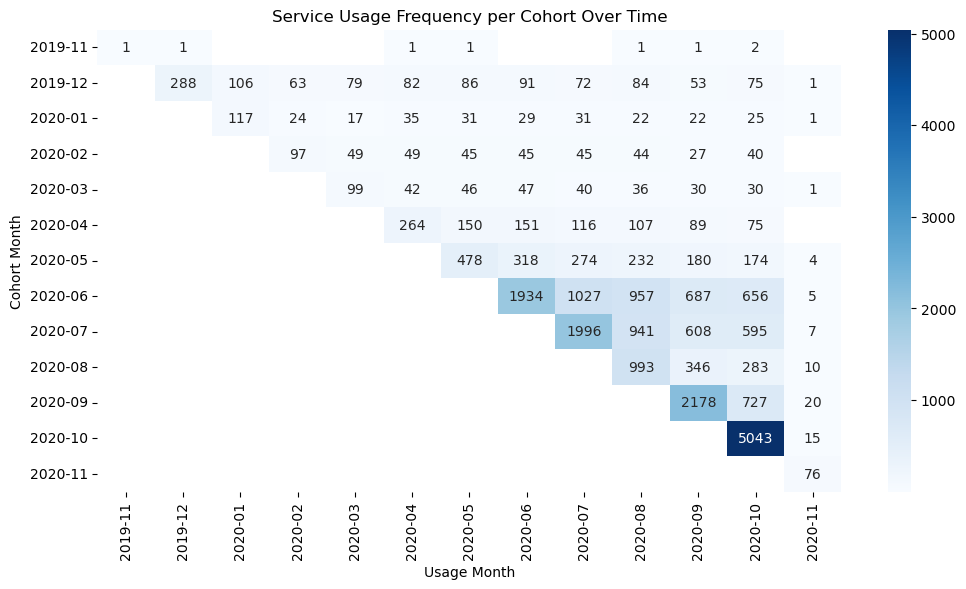

In [85]:
plt.figure(figsize=(12, 6))
sns.heatmap(usage_frequency_pivot,  annot=True, fmt='g', cmap='Blues')
plt.title("Service Usage Frequency per Cohort Over Time")
plt.ylabel("Cohort Month")
plt.xlabel("Usage Month")
plt.show()
#interpretation
#small user size in early cohorts --> possilby launch phase
#big increase in users from June 2020 on
#drop in use after first month --> retention curve?
#some cohorts more active in later month e.g. june 2020 vs july 2020

In [86]:
#fees.isnull().mean()

# Incident Rate: Determine the incident rate, specifically focusing on payment incidents, for each cohort. Identify if there are variations in incident rates among different cohorts.

In [87]:
#check type values >> find rows with type = incident
fees["type"].value_counts()

type
instant_payment    11095
postpone            7766
incident            2196
Name: count, dtype: int64

In [88]:
#define incidents
incidents = ["incident"]

#new boolean column for incident
fees["is_incident"] = fees["type"].isin(incidents)
fees

#calculate incidents per cash request
incidents_per_CR = fees.groupby(["cash_request_id"]).agg(total_incidents=("is_incident", "sum")).reset_index()
incidents_per_CR.value_counts()

cash_request_id  total_incidents
1456.0           0                  1
21989.0          0                  1
21979.0          0                  1
21980.0          0                  1
21981.0          0                  1
                                   ..
15804.0          0                  1
15805.0          0                  1
15807.0          0                  1
15808.0          0                  1
27010.0          0                  1
Name: count, Length: 12933, dtype: int64

In [89]:
#create incident rate per cohort

incidents_per_cohort = pd.merge(cash_request,incidents_per_CR, left_on="id", right_on="cash_request_id", how="left" )
incidents_per_cohort
incident_summary = incidents_per_cohort.groupby(["cohort_month"]).agg( total_requests=("id", "count"), total_incidents=("total_incidents", "sum")). reset_index()
incident_summary
incident_summary["incident_rate"] = incident_summary["total_incidents"] / incident_summary["total_requests"]
incident_summary

,cohort_month,total_requests,total_incidents,incident_rate
0,2019-11,8,0.0,0.000000
1,2019-12,1080,53.0,0.049074
2,2020-01,354,15.0,0.042373
3,2020-02,441,24.0,0.054422
4,2020-03,371,32.0,0.086253
5,2020-04,952,119.0,0.125000
6,2020-05,1660,234.0,0.140964
7,2020-06,5266,776.0,0.147360
8,2020-07,4147,576.0,0.138896
9,2020-08,1632,149.0,0.091299


Text(0, 0.5, 'Incident Rate')

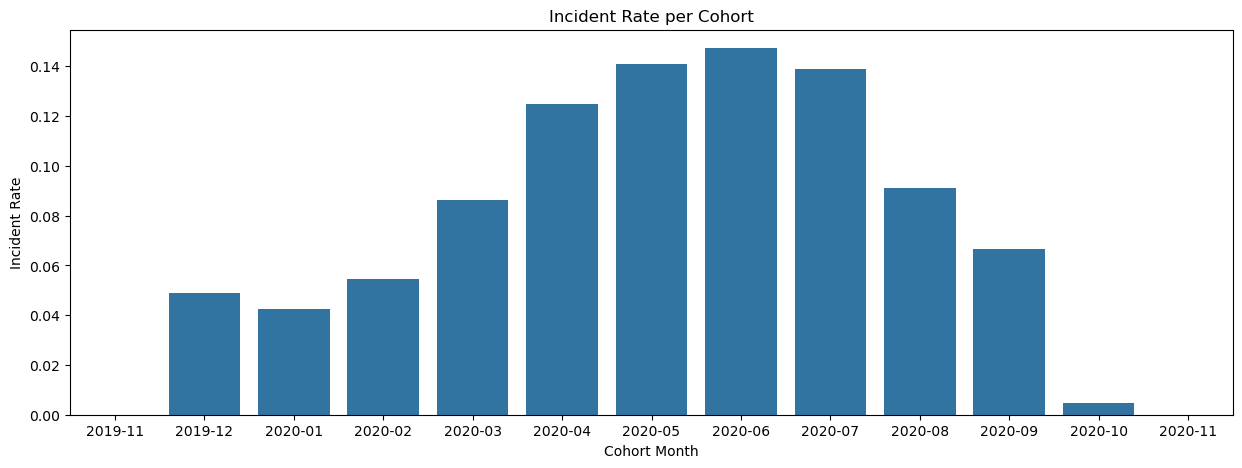

In [90]:
plt.figure(figsize = (15, 5))
sns.barplot(data=incident_summary, x="cohort_month", y = "incident_rate")
plt.title("Incident Rate per Cohort")
plt.xlabel("Cohort Month")
plt.ylabel("Incident Rate")

#analysis
#peaks in Jun 2020
#decrease from July on >> technological improvements? better incident management?

# Revenue Generated by the Cohort: Calculate the total revenue generated by each cohort over months to assess the financial impact of user behavior.

In [91]:
cash_request["created_at"] = pd.to_datetime(cash_request["created_at"])
#summing total amount by cash request in file fees because CR Ids are doubled
fees_by_cash_request = fees.groupby(["cash_request_id"]).agg({"total_amount" : "sum"}).reset_index()
fees_by_cash_request
#merging CR with summed fees by CR id
merged_df_2 = pd.merge(cash_request, fees_by_cash_request, left_on="id", right_on="cash_request_id", how="left")
merged_df_2

cash_request[["status", "reimbursement_date", "money_back_date"]]

,status,reimbursement_date,money_back_date
0,rejected,2020-01-09 19:05:21.596363+00:00,NaT
1,rejected,2020-01-09 19:50:12.347780+00:00,NaT
2,rejected,2020-01-09 19:13:35.825041+00:00,NaT
3,rejected,2020-01-09 19:16:10.879606+00:00,NaT
4,rejected,NaT,NaT
...,...,...,...
23965,money_back,NaT,2021-02-06 20:17:49.257521+00:00
23966,money_back,NaT,2020-12-01 13:26:53.787672+00:00
23967,money_back,NaT,2021-02-05 12:19:30.626289+00:00
23968,money_back,NaT,2021-02-05 13:14:19.689906+00:00


In [92]:
cohort_revenue = merged_df_2.groupby(["cohort_month", "usage_month"]).agg({"total_amount" : "sum"}).reset_index()
cohort_revenue

,cohort_month,usage_month,total_amount
0,2019-11,2019-11,0.0
1,2019-11,2019-12,0.0
2,2019-11,2020-04,0.0
3,2019-11,2020-05,25.0
4,2019-11,2020-08,10.0
...,...,...,...
78,2020-09,2020-10,4235.0
79,2020-09,2020-11,75.0
80,2020-10,2020-10,29445.0
81,2020-10,2020-11,55.0


In [93]:
cohort_revenue["cohort_month"] = cohort_revenue["cohort_month"].astype(str) #converting date to str so that we can use the column as index and column name later
cohort_revenue["usage_month"] = cohort_revenue["usage_month"].astype(str) #converting date to str
revenue_pivot = cohort_revenue.pivot(index = "cohort_month", columns="usage_month", values= "total_amount")
revenue_pivot

usage_month,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
cohort_month,,,,,,,,,,,,,
2019-11,0.0,0.0,NaN,NaN,NaN,0.0,25.0,NaN,NaN,10.0,5.0,10.0,NaN
2019-12,NaN,0.0,0.0,0.0,0.0,0.0,60.0,250.0,180.0,560.0,180.0,325.0,0.0
2020-01,NaN,NaN,0.0,0.0,0.0,0.0,40.0,45.0,160.0,145.0,125.0,140.0,0.0
2020-02,NaN,NaN,NaN,0.0,0.0,0.0,80.0,130.0,135.0,285.0,115.0,220.0,NaN
2020-03,NaN,NaN,NaN,NaN,0.0,0.0,10.0,225.0,90.0,185.0,155.0,200.0,5.0
2020-04,NaN,NaN,NaN,NaN,NaN,5.0,180.0,585.0,405.0,640.0,405.0,345.0,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,890.0,1120.0,935.0,1135.0,930.0,905.0,15.0
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6370.0,2615.0,5825.0,4160.0,3510.0,15.0
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5875.0,4925.0,3300.0,3055.0,20.0


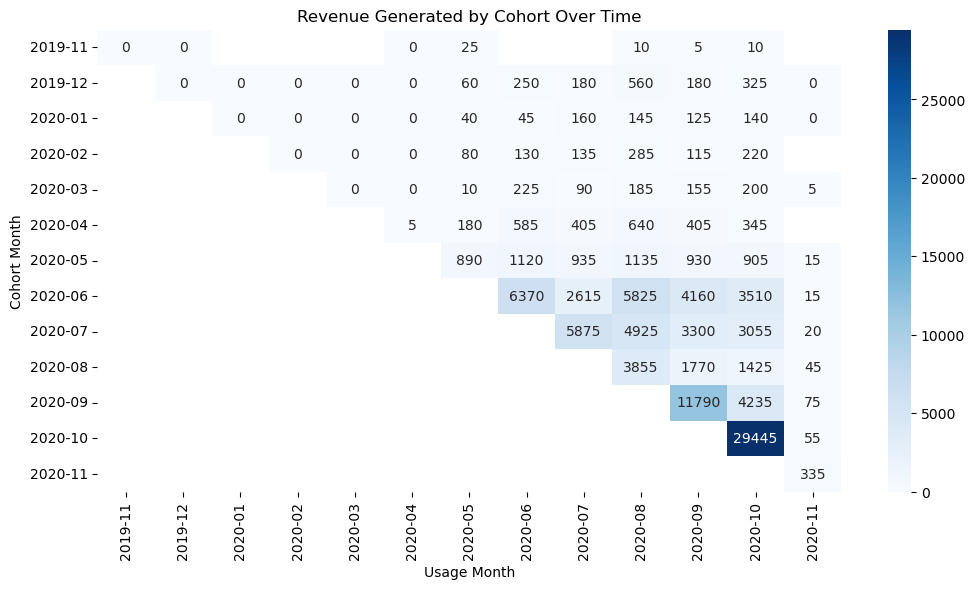

In [94]:
plt.figure(figsize=(12, 6))
sns.heatmap(revenue_pivot,  annot=True, fmt='g', cmap='Blues')
plt.title("Revenue Generated by Cohort Over Time")
plt.ylabel("Cohort Month")
plt.xlabel("Usage Month")
plt.show()
#analysis
#early cohorts generated no revenue, indicating initial phase / launch
#big spike in revenue in june, july >> product update? successful marketing campagne?
#later cohorts in sept, oct show spikes again >> changed user behavior? product updates, pricing updates?
#continuous revenue decrease over time >> first month has the highest reveneu followed by decreasing usage>> one-time usage? low retention?

In [95]:
fees["reason"].value_counts() #Filled only if the CR was manually reviewed and rejected. That's the rejection's reason displayed in-app.

reason
rejected direct debit                 1599
month delay on payment - 9/2020        283
month delay on payment - 8/2020        203
month delay on payment - 10/2020       102
Postpone Cash Request 12225             34
                                      ... 
Instant Payment Cash Request 21140       1
Instant Payment Cash Request 25010       1
Postpone Cash Request 16749              1
Instant Payment Cash Request 21100       1
Instant Payment Cash Request 20982       1
Name: count, Length: 15145, dtype: int64

Additional measures

In [104]:
# STATISTICS per usage month
statistics_per_usage_month = cash_request.groupby(["usage_month"]).agg({"exposure":"sum", "id" : "count", "time_to_reimburse" : "sum", "reimbursed_amount" : "sum"}).reset_index()
statistics_per_usage_month = statistics_per_usage_month.rename(columns={"id" : "count_CR"})
statistics_per_usage_month["AVG_CR"] = statistics_per_usage_month["exposure"] / statistics_per_usage_month["count_CR"]
statistics_per_usage_month["recovery_rate"] =  statistics_per_usage_month["reimbursed_amount"]  / statistics_per_usage_month["exposure"]
statistics_per_usage_month["outstanding_exposure"] = statistics_per_usage_month["exposure"] - statistics_per_usage_month["reimbursed_amount"]
#statistics_per_usage_month["AVG_time_to_reimburse"] = statistics_per_usage_month["time_to_reimburse"] / statistics_per_usage_month["count_CR"]

statistics_per_usage_month

,usage_month,exposure,count_CR,time_to_reimburse,reimbursed_amount,AVG_CR,recovery_rate,outstanding_exposure
0,2019-11,0.0,1,0.0,0.0,0.000000,NaN,0.0
1,2019-12,16849.0,289,2271.0,3219.0,58.301038,0.191050,13630.0
2,2020-01,10579.0,223,2782.0,6679.0,47.439462,0.631345,3900.0
3,2020-02,10725.0,184,1722.0,6985.0,58.288043,0.651282,3740.0
4,2020-03,16200.0,244,1104.0,15800.0,66.393443,0.975309,400.0
5,2020-04,31333.0,473,1426.0,31083.0,66.243129,0.992021,250.0
6,2020-05,57703.0,837,3447.0,53923.0,68.940263,0.934492,3780.0
7,2020-06,154133.0,2615,10184.0,90738.0,58.941874,0.588699,63395.0
8,2020-07,184541.0,3601,10931.0,43150.0,51.247154,0.233823,141391.0
9,2020-08,179786.0,3417,9624.0,109231.0,52.615159,0.607561,70555.0


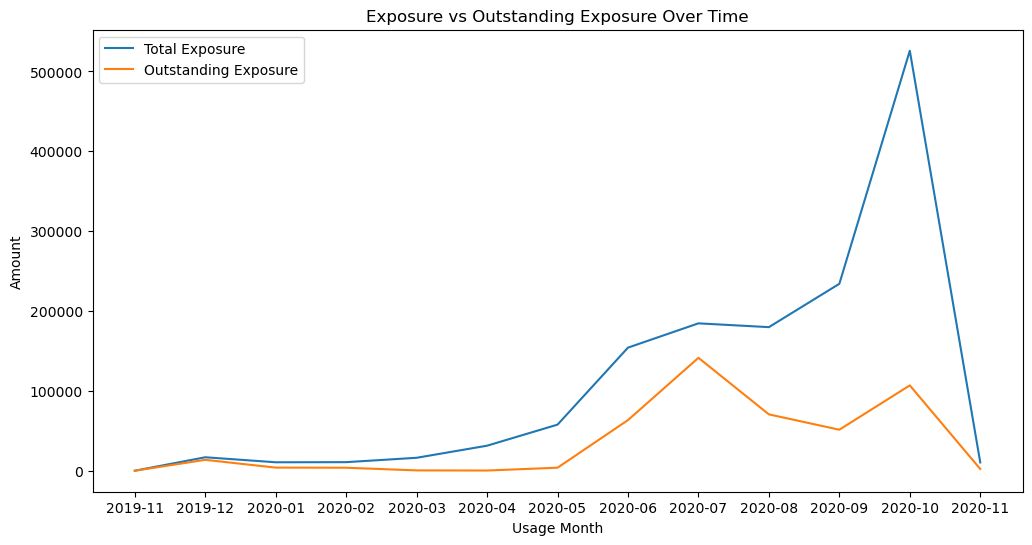

In [97]:
plt.figure(figsize=(12, 6))

statistics_per_usage_month["usage_month"] = statistics_per_usage_month["usage_month"].astype(str)
plt.plot(statistics_per_usage_month["usage_month"], statistics_per_usage_month["exposure"], label="Total Exposure")
plt.plot(statistics_per_usage_month["usage_month"], statistics_per_usage_month["outstanding_exposure"], label="Outstanding Exposure")

plt.title("Exposure vs Outstanding Exposure Over Time")
plt.xlabel("Usage Month")
plt.ylabel("Amount")
plt.xticks()
plt.legend()
plt.show()

#analysis: customers are paying back what they borrowed - even as lending increases >> good signal of repayment behavior and credit portfolio health

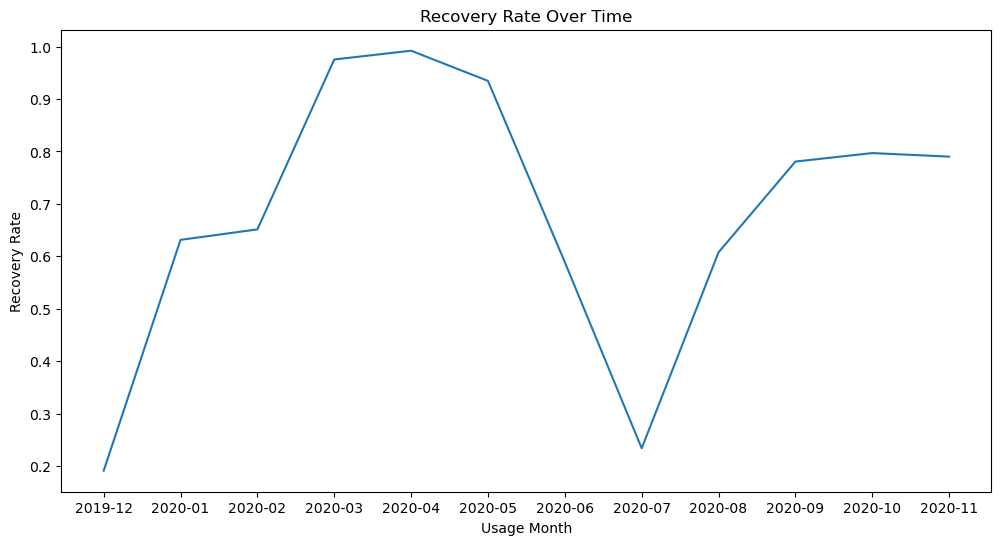

In [98]:
#recovery rate = tells us how much of the exposure has been recoverd. the higher the better
plt.figure(figsize=(12, 6))
sns.lineplot(data=statistics_per_usage_month, x='usage_month', y='recovery_rate')
plt.title("Recovery Rate Over Time")
plt.xlabel("Usage Month")
plt.ylabel("Recovery Rate")
plt.show()
#analysis: a dip in July 2020, but after a steady rise >> higher proportion of the money borrowed is being recovered

In [100]:
statistics_per_cohort_and_usage = cash_request.groupby(["cohort_month", "usage_month"]).agg({"amount":"sum", "reimbursed_amount" : "sum", "id":"count"}).reset_index()
statistics_per_cohort_and_usage = statistics_per_cohort_and_usage.rename(columns={"amount" : "exposure", "reimbursed_amount" : "recovered_amount"})
statistics_per_cohort_and_usage["cohort_month"] = statistics_per_cohort_and_usage["cohort_month"].astype(str) #converting date to str
statistics_per_cohort_and_usage["usage_month"] = statistics_per_cohort_and_usage["usage_month"].astype(str) #converting date to str
statistics_per_cohort_and_usage["recovery_rate"] =  statistics_per_cohort_and_usage["recovered_amount"]  / statistics_per_cohort_and_usage["exposure"]
statistics_per_cohort_and_usage["outstanding_exposure"] = statistics_per_cohort_and_usage["exposure"] - statistics_per_cohort_and_usage["recovered_amount"]
statistics_per_cohort_and_usage["exposure_per_request"] =  statistics_per_cohort_and_usage["exposure"]  / statistics_per_cohort_and_usage["id"]
statistics_per_cohort_and_usage


,cohort_month,usage_month,exposure,recovered_amount,id,recovery_rate,outstanding_exposure,exposure_per_request
0,2019-11,2019-11,1.0,0.0,1,0.000000,1.0,1.000000
1,2019-11,2019-12,100.0,0.0,1,0.000000,100.0,100.000000
2,2019-11,2020-04,100.0,100.0,1,1.000000,0.0,100.000000
3,2019-11,2020-05,10.0,10.0,1,1.000000,0.0,10.000000
4,2019-11,2020-08,10.0,0.0,1,0.000000,10.0,10.000000
...,...,...,...,...,...,...,...,...
78,2020-09,2020-10,49865.0,37425.0,727,0.750526,12440.0,68.590096
79,2020-09,2020-11,1475.0,1125.0,20,0.762712,350.0,73.750000
80,2020-10,2020-10,346445.0,269865.0,5043,0.778955,76580.0,68.698196
81,2020-10,2020-11,1200.0,800.0,15,0.666667,400.0,80.000000


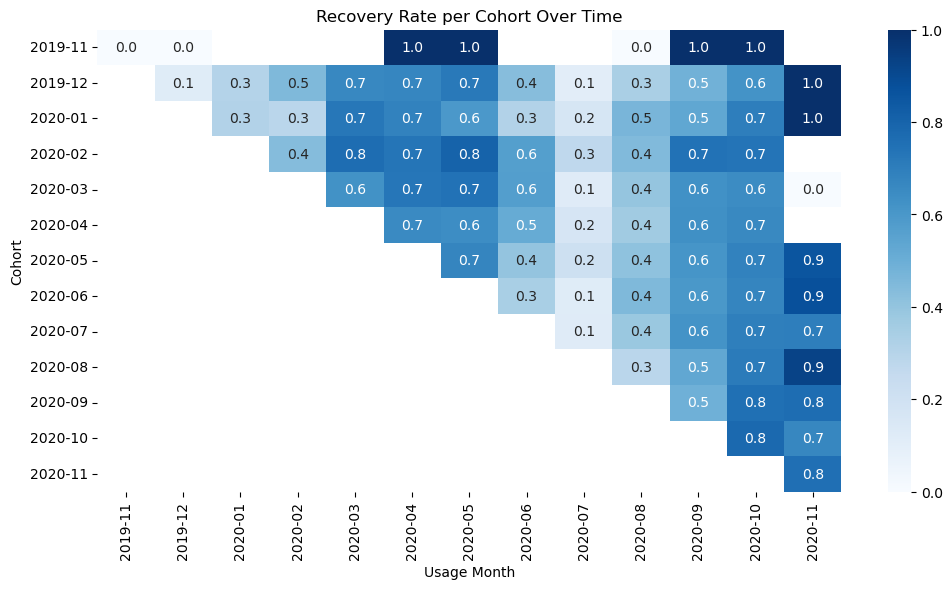

In [101]:
# recovery rate per cohort over time
statistics_recovery_rate_pivot = statistics_per_cohort_and_usage.pivot(index="cohort_month", columns="usage_month", values="recovery_rate")
plt.figure(figsize=(12, 6))
sns.heatmap(statistics_recovery_rate_pivot,  annot=True, fmt='.1f', cmap='Blues')
plt.title("Recovery Rate per Cohort Over Time")
plt.ylabel("Cohort")
plt.xlabel("Usage Month")
plt.show()

# y-axis: Cohort = the month a user first used the cash advance service
# x-axis: Usage Month = months after their first request (same or following months)
# values: Recovery Rate = % of lent money that was repaid by users from that cohort in that month

# Strong repayment performance for older cohorts: cohorts from 2019-12 to 2020-03 show steady and improving recovery rates, reaching close to 1.0 within 6–9 months 
# Newer cohorts (mid-2020 onward) are showing solid recovery rates (0.7–0.9) within 2–3 months >> even with increased lending volume, users are still repaying well

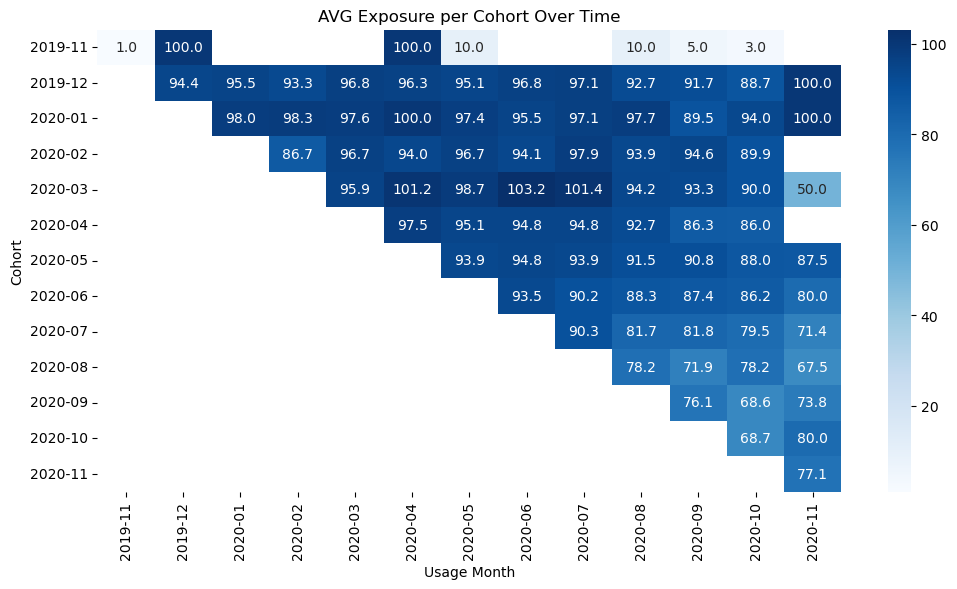

In [102]:
# exposure per cohort over time
exposure_per_cohort_pivot = statistics_per_cohort_and_usage.pivot(index="cohort_month", columns="usage_month", values="exposure_per_request")

plt.figure(figsize=(12, 6))
sns.heatmap(exposure_per_cohort_pivot,  annot=True, fmt='.1f', cmap='Blues')
plt.title("AVG Exposure per Cohort Over Time")
plt.ylabel("Cohort")
plt.xlabel("Usage Month")
plt.show()

In [103]:
#ideas for other KPIs: revenue on risk >> revenue with an incident
#exposure at risk >> borrowed money
#time to repayment



In [ ]:
plt.plot(statistics_per_usage_month["usage_month"], statistics_per_usage_month["exposure"], label="Total Exposure")
plt.plot(statistics_per_usage_month["usage_month"], statistics_per_usage_month["outstanding_exposure"], label="Outstanding Exposure")

plt.title("Exposure vs Outstanding Exposure Over Time")
plt.xlabel("Usage Month")
plt.ylabel("Amount")
plt.xticks()
plt.legend()
plt.show()

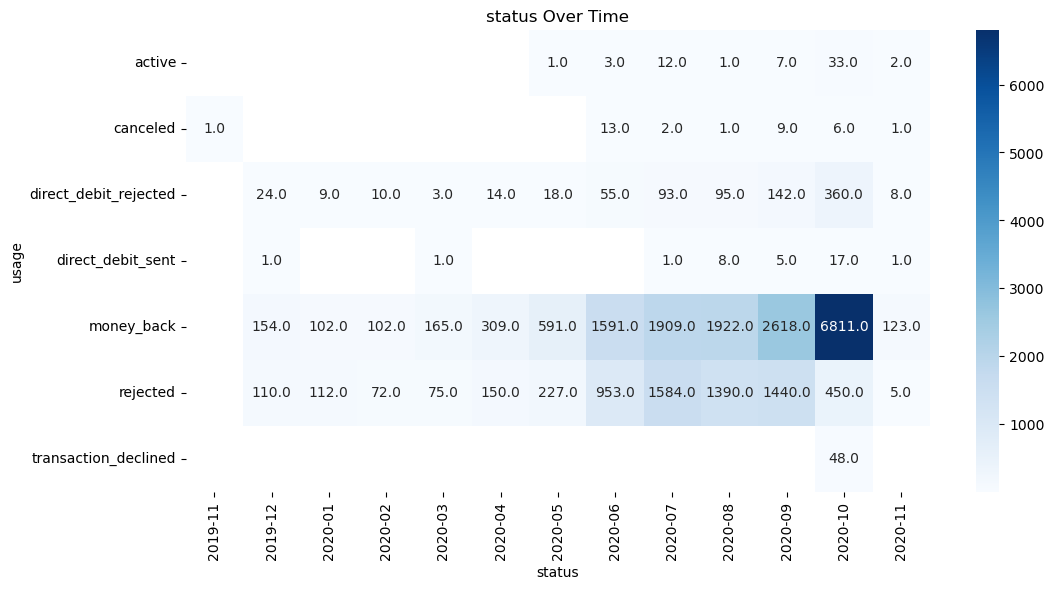

In [111]:
statistics_per_status = cash_request.groupby(["usage_month", "status"]).agg({"id":"count"}).reset_index()
statistics_per_status_pivot = statistics_per_status.pivot(index="status", columns="usage_month", values="id")
plt.figure(figsize=(12, 6))
sns.heatmap(statistics_per_status_pivot,  annot=True, fmt='.1f', cmap='Blues')
plt.title("status Over Time")
plt.ylabel("usage")
plt.xlabel("status")
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(statistics_recovery_rate_pivot,  annot=True, fmt='.1f', cmap='Blues')
plt.title("Recovery Rate per Cohort Over Time")
plt.ylabel("Cohort")
plt.xlabel("Usage Month")
plt.show()
